# Visión por Computadora 1

## Trabajo Práctico 2

---

### **Objetivo**
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.<br>
    3. Opcional: Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3)<br>

    Para cada experimento se debe presentar:
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque. <br>

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure 
operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera 
automática.

Puntos extra: Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.


---

### **Desarrollo**

#### **1. Detector de Máximo Enfoque aplicando técnicas de Análisis Espectral**

#### **Basado en paper: "Image Sharpness Measure for Blurred Images in Frequency Domain" (Kanjar De & Masilamani)** 

La idea fundamental es que las imágenes nítidas poseen más energía en altas frecuencias, mientras que el desenfoque actúa como un filtro pasa-bajos.
Según lo explicado en este paper, la nitidez se estima mediante los siguientes pasos:

1. Se calcula la transformada de Fourier 2D de la imagen: 
$$ F = \mathcal{F}(I) $$

2. Se aplica `fftshift` para centrar el espectro:

$$
F_c = \text{fftshift}(F)
$$

3. Se obtiene la magnitud del espectro centrado:

$$
A_F = |F_c|
$$

4. Obtener el valor máximo (se usa para definir un umbral adaptativo):

$$
M = \max(A_F)
$$


5. Contar componentes de alta frecuencia:

    Se fija un umbral proporcional al máximo y se cuenta cuántos coeficientes superan el umbral:

$$
\text{thres} = \frac{M}{1000}
$$   

$$
T_H = \#{A_F(x,y) > \text{thres}}
$$

6. Calcular el índice de nitidez (FM), representada por el conteo normalizado por la cantidad total de píxeles:

$$
FM = \frac{T_H}{N_\text{pix}}
$$

donde $ N_\text{pix} = \text{alto} \times \text{ancho} $ de la imagen.


Cuanto **mayor sea \(FM\)**, **más nítida** es la imagen.  
Cuando la imagen se vuelve borrosa, disminuyen las altas frecuencias y por lo tanto **disminuye el valor de la métrica**.



In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Play, HBox, VBox, jslink
from math import ceil
import os

def focus_measure_fft(gray):
    gray = gray.astype(np.float32)
    F = np.fft.fft2(gray)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    M = AF.max()
    if M == 0:
        return 0.0
    thres = M / 1000.0
    TH = np.sum(AF > thres)

    return TH / (gray.size)


#### **Métodos de medición**

1. **Medición sobre el frame completo**
Usamos la imagen completa para calcular `FM`.

2. **Medición sobre ROI central**
Seleccionamos una región central tal que:

$$
Área_{ROI} = p \times Área_{frame}
$$
donde $ p = 0.05 = 5\%$   y   $p = 0.10 = 10\% $  

3. **Matriz de enfoque (NxM)**
Se divide el frame en una grilla NxM y se calcula `FM` en cada celda. Luego tomamos la media como métrica global del frame.
Esto es similar a los módulos de autofocus por múltiples zonas utilizados en cámaras digitales.


In [15]:
def central_roi_coords(h, w, area_fraction):
    total_area = h * w
    target_area = total_area * area_fraction
    aspect = w / h

    h_roi = int(np.sqrt(target_area / aspect))
    w_roi = int(np.sqrt(target_area * aspect))

    y0 = (h - h_roi) // 2
    x0 = (w - w_roi) // 2

    return x0, y0, w_roi, h_roi


def grid_cells(h, w, N, M):
    cell_h = h // N
    cell_w = w // M
    cells = []

    for i in range(N):
        for j in range(M):
            y0 = i * cell_h
            x0 = j * cell_w

            h_cell = cell_h if i < N-1 else h - y0
            w_cell = cell_w if j < M-1 else w - x0

            cells.append((x0, y0, w_cell, h_cell))
    return cells


#### **Procesamiento del video**

Para cada frame del video:

1. Convertimos a escala de grises.
2. Calculamos:
   - *FM_full*
   - *FM_ROI_5%*, *FM_ROI_10%*
   - *FM_grid_3x3, FM_grid_5x7, FM_grid_7x5*
3. Almacenamos los valores para graficar más tarde.

Luego detectaremos automáticamente el frame de máximo enfoque usando:      $$ \text{arg max}(FM)$$


In [16]:
VIDEO_PATH = "focus_video.mov"

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError("No se pudo abrir focus_video.mov")

metrics_full = []
metrics_roi_5  = []
metrics_roi_10 = []
metrics_grid_3x3 = []
metrics_grid_5x7 = []
metrics_grid_7x5 = []

ret, frame = cap.read()
h, w = frame.shape[:2]
print("Resolución del video: {}x{}".format(w, h))

frame_count = 0

while ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1) Full frame
    metrics_full.append(focus_measure_fft(gray))

    # 2) ROI 5%
    x,y,w_roi,h_roi = central_roi_coords(h,w,0.05)
    roi = gray[y:y+h_roi, x:x+w_roi]
    metrics_roi_5.append(focus_measure_fft(roi))

    # 3) ROI 10%
    x,y,w_roi,h_roi = central_roi_coords(h,w,0.10)
    roi = gray[y:y+h_roi, x:x+w_roi]
    metrics_roi_10.append(focus_measure_fft(roi))

    # 4) Grids
    # 3x3
    fm_cells = []
    for (x0, y0, wc, hc) in grid_cells(h,w,3,3):
        cell = gray[y0:y0+hc, x0:x0+wc]
        fm_cells.append(focus_measure_fft(cell))
    metrics_grid_3x3.append(np.mean(fm_cells))

    # 5x7
    fm_cells = []
    for (x0, y0, wc, hc) in grid_cells(h,w,5,7):
        cell = gray[y0:y0+hc, x0:x0+wc]
        fm_cells.append(focus_measure_fft(cell))
    metrics_grid_5x7.append(np.mean(fm_cells))

    # 7x5
    fm_cells = []
    for (x0, y0, wc, hc) in grid_cells(h,w,7,5):
        cell = gray[y0:y0+hc, x0:x0+wc]
        fm_cells.append(focus_measure_fft(cell))
    metrics_grid_7x5.append(np.mean(fm_cells))

    ret, frame = cap.read()
    frame_count += 1

cap.release()

print("Frames procesados:", frame_count)


Resolución del video: 640x360
Frames procesados: 171


#### **Visualización**

A continuación se visualizan las siguientes métricas de enfoque calculadas:
- Full frame  
- ROI 5%  
- ROI 10%  
- Grid 3×3  
- Grid 5×7  
- Grid 7×5  

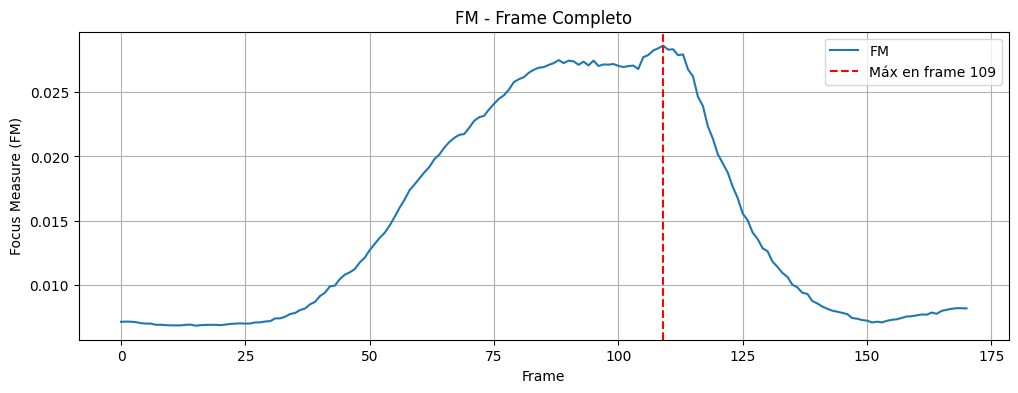

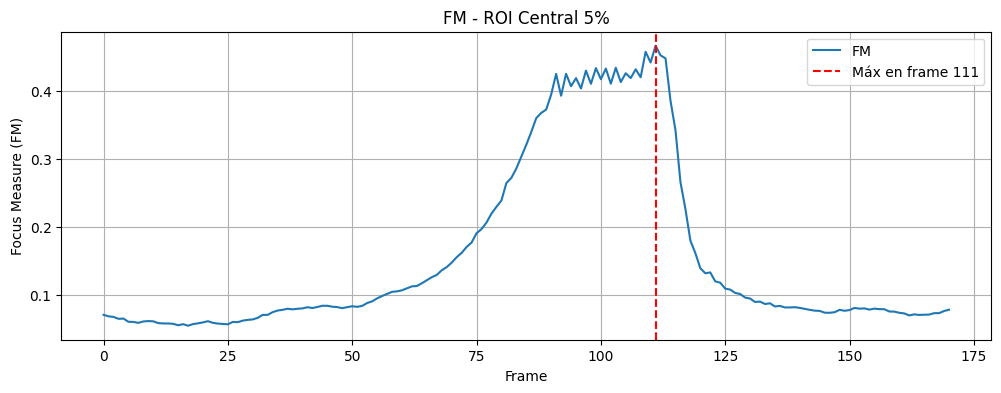

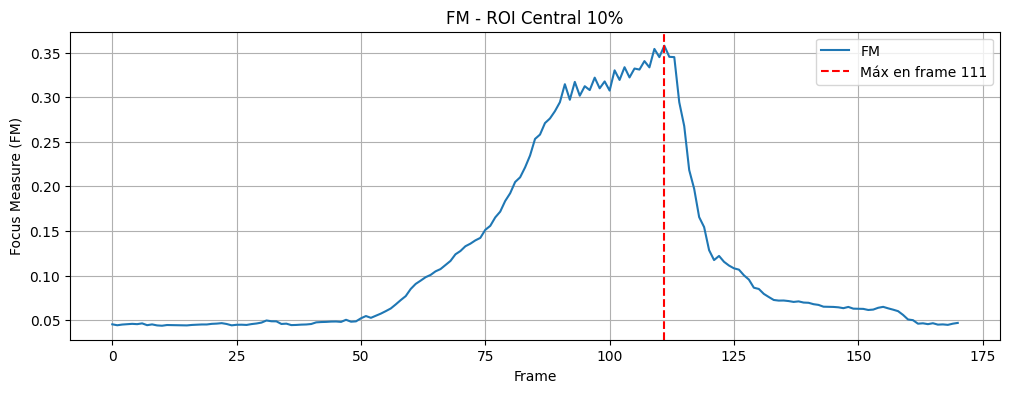

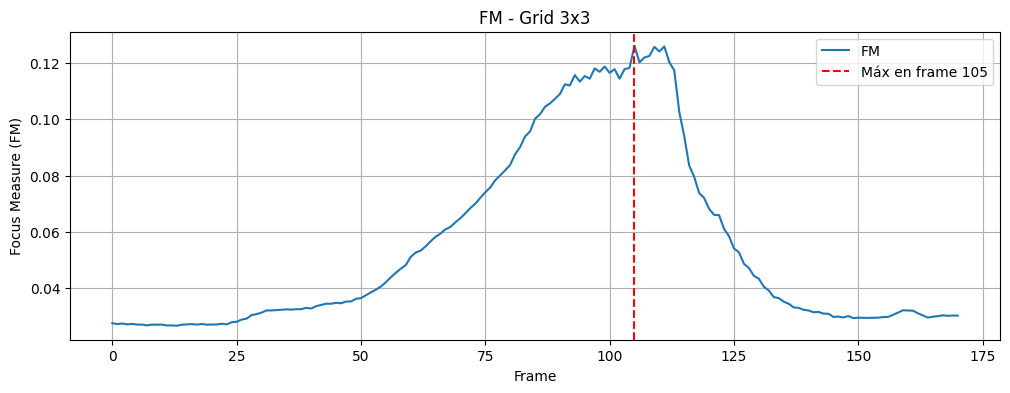

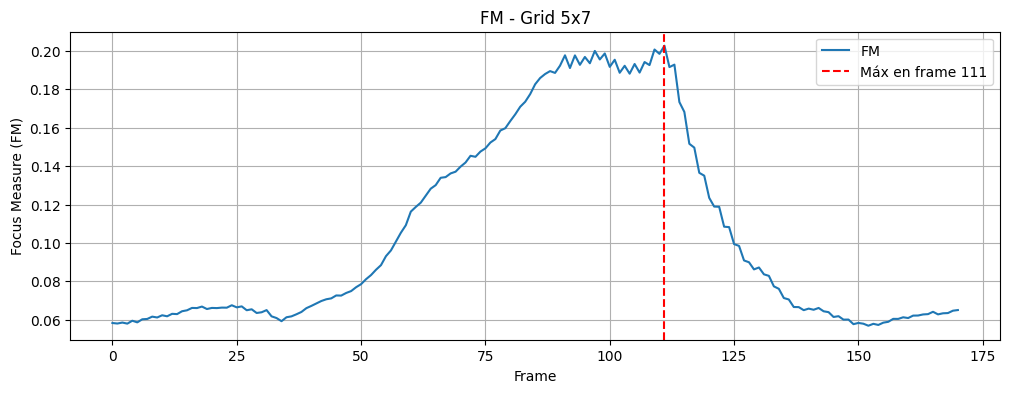

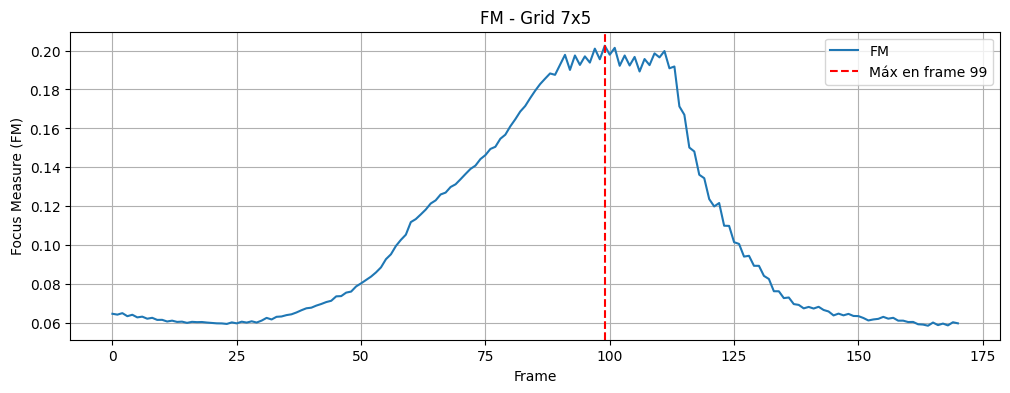

In [17]:
def plot_metric(values, title):
    plt.figure(figsize=(12,4))
    plt.plot(values, label="FM")
    idx_max = np.argmax(values)
    plt.axvline(idx_max, color='red', linestyle='--', label=f"Máx en frame {idx_max}")
    plt.title(title)
    plt.xlabel("Frame")
    plt.ylabel("Focus Measure (FM)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return idx_max

idx_full = plot_metric(metrics_full, "FM - Frame Completo")
idx_roi5 = plot_metric(metrics_roi_5, "FM - ROI Central 5%")
idx_roi10 = plot_metric(metrics_roi_10, "FM - ROI Central 10%")
idx_3x3 = plot_metric(metrics_grid_3x3, "FM - Grid 3x3")
idx_5x7 = plot_metric(metrics_grid_5x7, "FM - Grid 5x7")
idx_7x5 = plot_metric(metrics_grid_7x5, "FM - Grid 7x5")


---

#### **Conclusiones Punto 1:**

1. Frame completo

    La métrica aplicada sobre el frame completo produjo la curva más limpia y estable. El pico de enfoque está claramente definido y es fácil de detectar. Este método resultó más robusto porque integra información de toda la escena y minimiza el ruido local.

2. ROIs centrales (5% y 10%)

    La métrica aplicada sobre regiones centrales pequeñas introduce un poco de ruido debido a variaciones locales. 
    - ROI 5%: curva más ruidosa y sensible al detalle local.

    - ROI 10%: más estable y con pico un poco más definido.

    En ambos casos el pico se detecta correctamente, pero con menor claridad que en el análisis global.

3. Grillas (3×3, 5×7, 7×5)

    Las grillas dividen el análisis en áreas pequeñas y por eso introducen más ruido que el frame completo. Aun así, capturan la evolución general del enfoque.

    Un caso particular es la grilla 5×7 (transpuesta de la 7x5), que presentó corrimiento en la detección del máximo, unos 10 frames antes que el resto. Esto muestra que el contenido espacial de la escena influye en cómo la grilla promedia la nitidez.

**General**

La métrica FFT identifica el punto de máximo enfoque de forma confiable en todas las configuraciones. El análisis del frame completo es el más robusto, pero las diferencias con ROIs y grillas son mínimas (detectan el máximo en frames próximos). Por eso, la elección del método debe ser un compromiso entre robustez y velocidad: el frame completo ofrece mayor estabilidad, mientras que ROIs y grillas permiten reducir procesamiento con una pérdida muy pequeña de precisión.

---

---

### **2. Métrica de enfoque elegida: SML (Sum of Modified Laplacian)**

#### **Basado en paper: "Analysis of Focus Measure Operators in Shape-from-Focus"** 

La idea central es evaluar qué tan fuertes son las variaciones locales de intensidad de la imagen. Cuando la imagen está enfocada, las transiciones son bruscas. Cuando está desenfocada, se suavizan.


**Pasos:**

1. Se convierte la imagen a escala de grises: 
$$ I = \text{gray(frame)} $$

2. Se calcula el laplaciano modificado por cada pixel (mide cambios abruptos en ambas direcciones):

$$
ML(x,y) = \left|\, I(x+1,y) - 2I(x,y) + I(x-1,y) \,\right|+\left|\, I(x,y+1) - 2I(x,y) + I(x,y-1) \,\right|
$$

3. Sumar el operador ML en toda la imagen (ese valor será grande cuando la imagen está enfocada y chico cuando sea borrosa):

$$
FM_{SML} = \sum_{x,y} ML(x,y)
$$ 


4. Se repite el proceso para cada frame y se obtiene una curva de evolución del enfoque a lo largo del tiempo.


5. Identificar el frame más enfocado (el máximo de la curva o mayor valor de FM):

    Cuanto **mayor sea \(FM\)**, **más nítida** es la imagen.  
    Cuando la imagen se vuelve borrosa, disminuyen los bordes abruptos y por lo tanto **disminuye el valor de la métrica**.


In [33]:
def focus_measure_sml(gray):
 
    gray = gray.astype(np.float32)

    MLx = np.abs(gray[:, 2:] - 2 * gray[:, 1:-1] + gray[:, :-2])
    MLy = np.abs(gray[2:, :] - 2 * gray[1:-1, :] + gray[:-2, :])

    h = min(MLx.shape[0], MLy.shape[0])
    w = min(MLx.shape[1], MLy.shape[1])

    ML = MLx[:h, :w] + MLy[:h, :w]
    return np.sum(ML) / (gray.size)


def unsharp_mask(image, amount=1.0, sigma=1.0):
    image = image.astype(np.float32)
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    mask = image - blurred
    sharpened = image + amount * mask
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    return sharpened


In [34]:
cap = cv2.VideoCapture(VIDEO_PATH)

# ---- SML ----
metrics_sml_full = []
metrics_sml_roi_5  = []
metrics_sml_roi_10 = []
metrics_sml_grid_3x3 = []
metrics_sml_grid_5x7 = []
metrics_sml_grid_7x5 = []

# ---- SML + Unsharp Mask ----
metrics_sml_um_full = []
metrics_sml_um_roi_5  = []
metrics_sml_um_roi_10 = []
metrics_sml_um_grid_3x3 = []
metrics_sml_um_grid_5x7 = []
metrics_sml_um_grid_7x5 = []

frames_rgb = []  # para visualizar luego

ret, frame = cap.read()
frame_count = 0

while ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames_rgb.append(rgb)

    # Unsharp Mask
    gray_um = unsharp_mask(gray, amount=1.0, sigma=1.0)

    # ---------- 1) FULL FRAME ----------
    metrics_sml_full.append(focus_measure_sml(gray))
    metrics_sml_um_full.append(focus_measure_sml(gray_um))

    # ---------- 2) ROI 5% ----------
    x, y, w_roi, h_roi = central_roi_coords(h, w, 0.05)
    roi       = gray[y:y+h_roi,    x:x+w_roi]
    roi_um    = gray_um[y:y+h_roi, x:x+w_roi]

    metrics_sml_roi_5.append(focus_measure_sml(roi))
    metrics_sml_um_roi_5.append(focus_measure_sml(roi_um))


    # ---------- 3) ROI 10% ----------
    x, y, w_roi, h_roi = central_roi_coords(h, w, 0.10)
    roi       = gray[y:y+h_roi,    x:x+w_roi]
    roi_um    = gray_um[y:y+h_roi, x:x+w_roi]

    metrics_sml_roi_10.append(focus_measure_sml(roi))
    metrics_sml_um_roi_10.append(focus_measure_sml(roi_um))


    # ---------- 4) GRID 3×3 ----------
    fm_cells_sml = []
    fm_cells_sml_um = []
    for (x0, y0, wc, hc) in grid_cells(h, w, 3, 3):
        cell    = gray[y0:y0+hc,    x0:x0+wc]
        cell_um = gray_um[y0:y0+hc, x0:x0+wc]
        fm_cells_sml.append(focus_measure_sml(cell))
        fm_cells_sml_um.append(focus_measure_sml(cell_um))

    metrics_sml_grid_3x3.append(np.mean(fm_cells_sml))
    metrics_sml_um_grid_3x3.append(np.mean(fm_cells_sml_um))


    # ---------- 5) GRID 5×7 ----------
    fm_cells_sml = []
    fm_cells_sml_um = []
    for (x0, y0, wc, hc) in grid_cells(h, w, 5, 7):
        cell = gray[y0:y0+hc, x0:x0+wc]
        cell_um = gray_um[y0:y0+hc, x0:x0+wc]
        fm_cells_sml.append(focus_measure_sml(cell))
        fm_cells_sml_um.append(focus_measure_sml(cell_um))

    metrics_sml_grid_5x7.append(np.mean(fm_cells_sml))
    metrics_sml_um_grid_5x7.append(np.mean(fm_cells_sml_um))


    # ---------- 6) GRID 7×5 ----------
    fm_cells_sml = []
    fm_cells_sml_um = []
    for (x0, y0, wc, hc) in grid_cells(h, w, 7, 5):
        cell = gray[y0:y0+hc, x0:x0+wc]
        cell_um = gray_um[y0:y0+hc, x0:x0+wc]
        fm_cells_sml.append(focus_measure_sml(cell))
        fm_cells_sml_um.append(focus_measure_sml(cell_um))

    metrics_sml_grid_7x5.append(np.mean(fm_cells_sml))
    metrics_sml_um_grid_7x5.append(np.mean(fm_cells_sml_um))

    ret, frame = cap.read()
    frame_count += 1

cap.release()

print("Frames procesados (Punto 2 - SML y SML+UM):", frame_count)



Frames procesados (Punto 2 - SML y SML+UM): 171


#### **Visualización**

A continuación se visualizan las siguientes métricas de enfoque calculadas:
- SML
- SML + Unsharp Masking

=== FULL FRAME ===


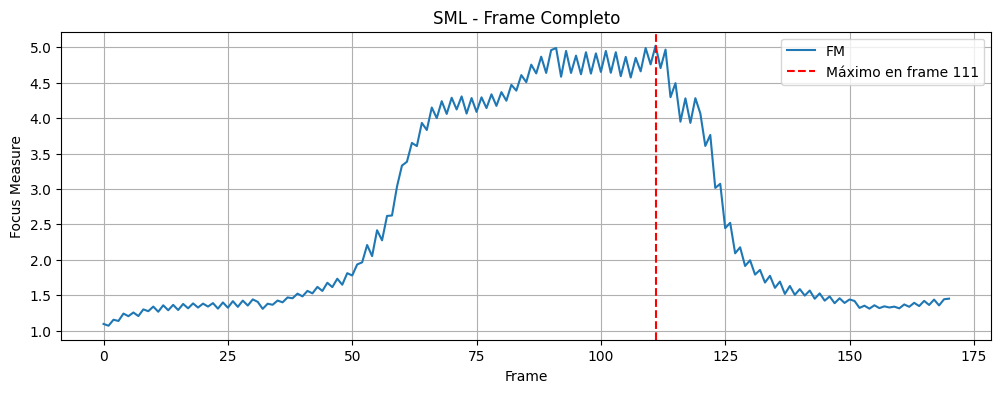

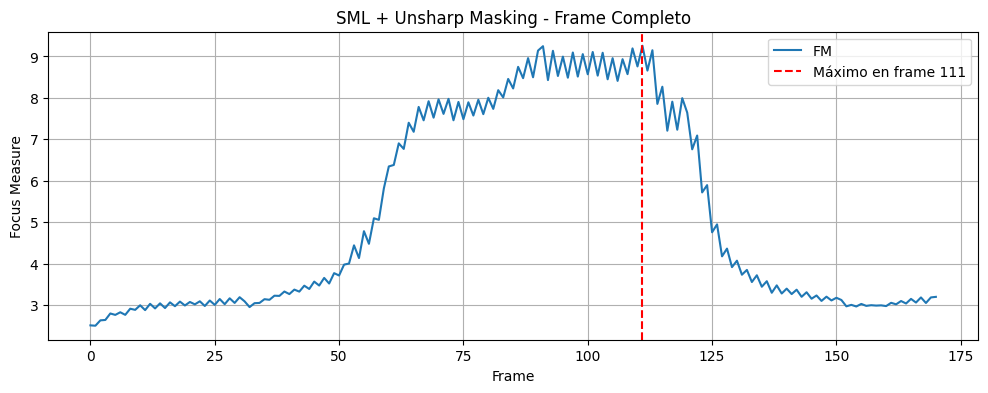

=== ROIs ===


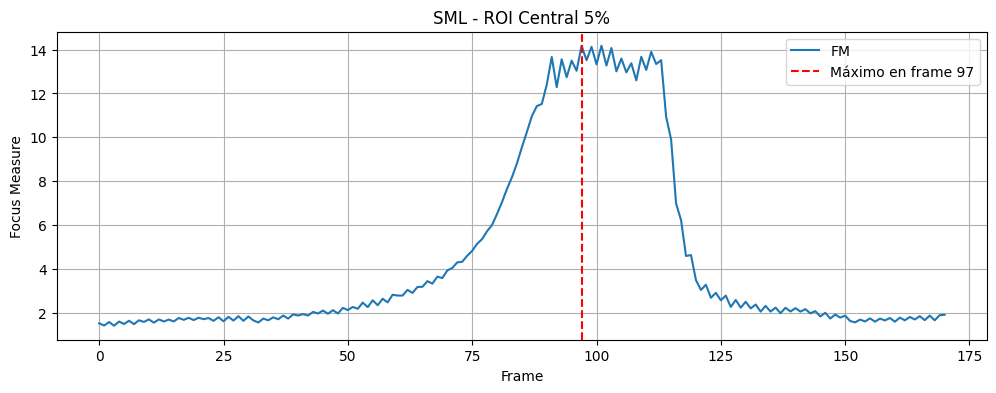

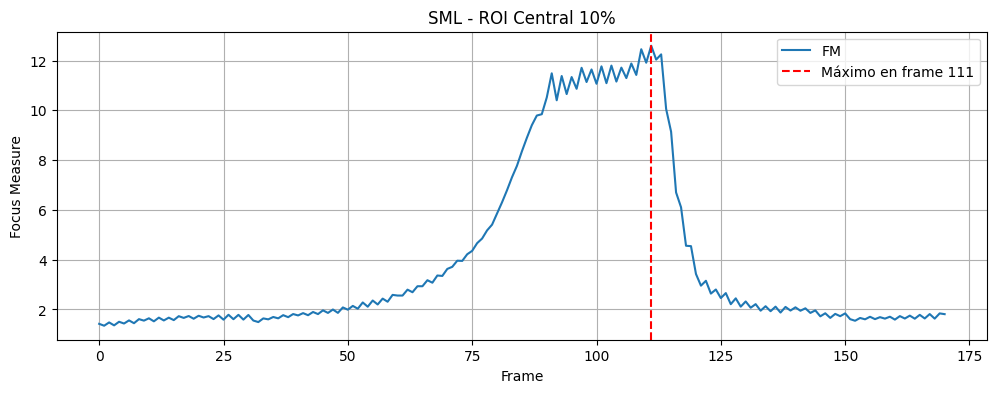

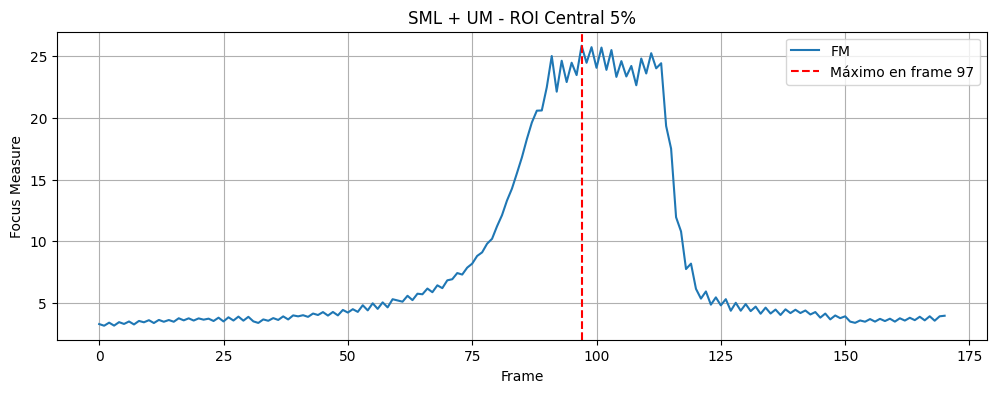

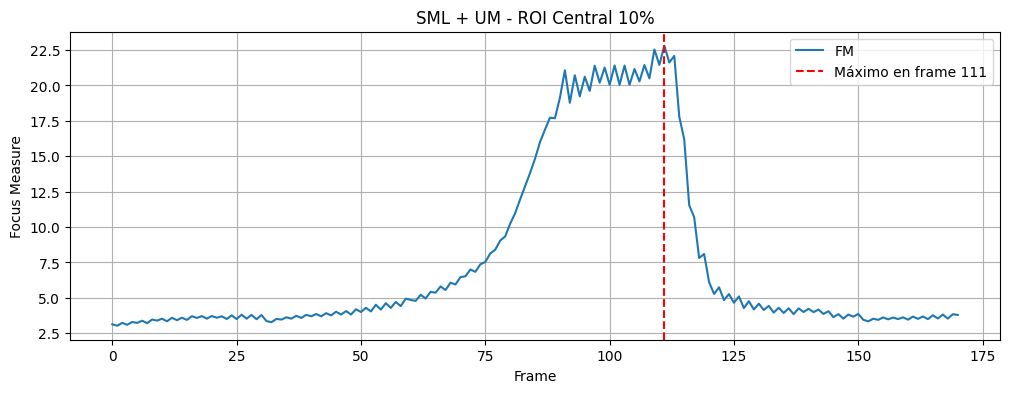

=== GRIDS ===


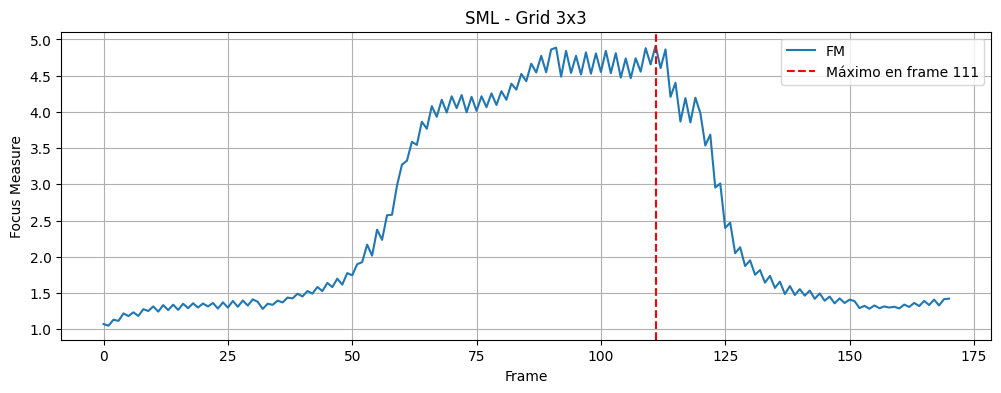

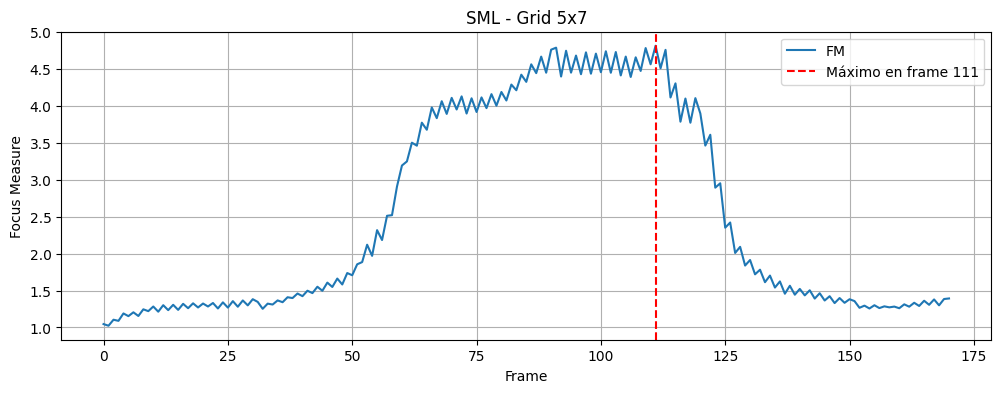

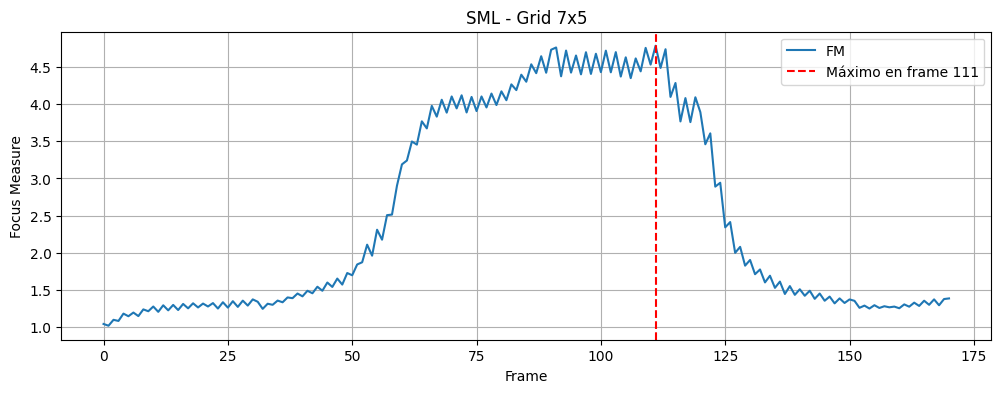

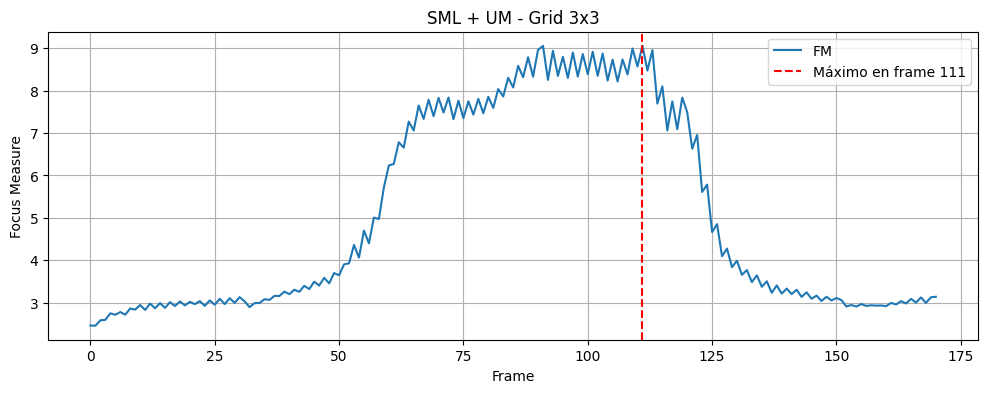

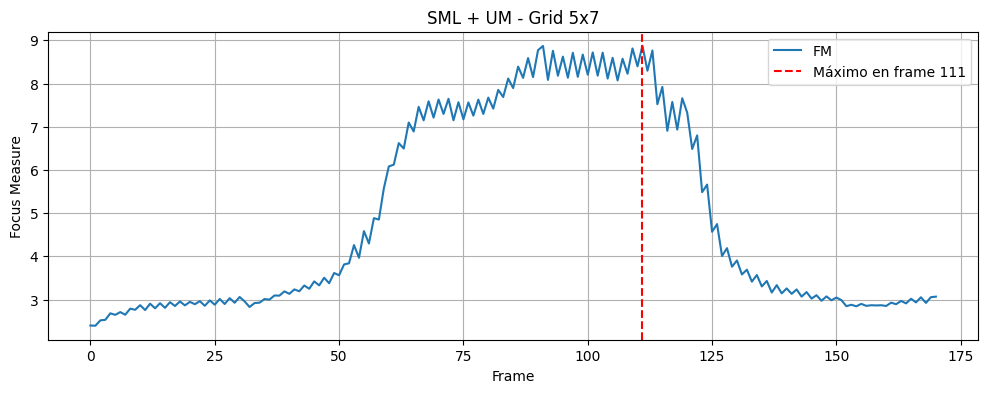

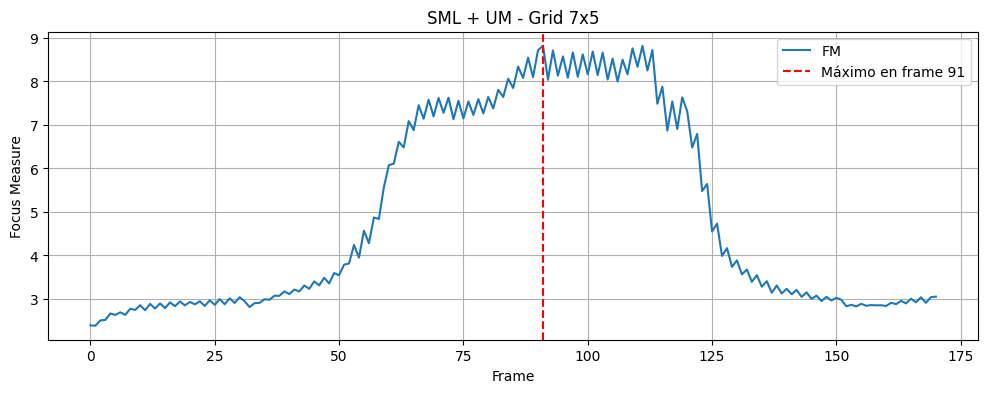

In [35]:
def plot_metric(values, title):
    plt.figure(figsize=(12, 4))
    plt.plot(values, label="FM")
    idx_max = np.argmax(values)
    plt.axvline(idx_max, color='red', linestyle='--', label=f"Máximo en frame {idx_max}")
    plt.title(title)
    plt.xlabel("Frame")
    plt.ylabel("Focus Measure")
    plt.legend()
    plt.grid(True)
    plt.show()
    return idx_max

# 1) FULL FRAME
print("=== FULL FRAME ===")
idx_sml_full = plot_metric(metrics_sml_full, "SML - Frame Completo")
idx_sml_um_full = plot_metric(metrics_sml_um_full, "SML + Unsharp Masking - Frame Completo")

# 2) ROIs
print("=== ROIs ===")
idx_sml_roi5 = plot_metric(metrics_sml_roi_5, "SML - ROI Central 5%")
idx_sml_roi10 = plot_metric(metrics_sml_roi_10, "SML - ROI Central 10%")

idx_sml_um_roi5 = plot_metric(metrics_sml_um_roi_5, "SML + UM - ROI Central 5%")
idx_sml_um_roi10 = plot_metric(metrics_sml_um_roi_10, "SML + UM - ROI Central 10%")

# 3) GRIDS
print("=== GRIDS ===")
idx_sml_grid_3x3 = plot_metric(metrics_sml_grid_3x3, "SML - Grid 3x3")
idx_sml_grid_5x7 = plot_metric(metrics_sml_grid_5x7, "SML - Grid 5x7")
idx_sml_grid_7x5 = plot_metric(metrics_sml_grid_7x5, "SML - Grid 7x5")

idx_sml_um_grid_3x3 = plot_metric(metrics_sml_um_grid_3x3, "SML + UM - Grid 3x3")
idx_sml_um_grid_5x7 = plot_metric(metrics_sml_um_grid_5x7, "SML + UM - Grid 5x7")
idx_sml_um_grid_7x5 = plot_metric(metrics_sml_um_grid_7x5, "SML + UM - Grid 7x5")


#### **Conclusiones Punto 2:**
En general, SML y SML+UM detectaron el máximo enfoque en el mismo frame (111) en todas las configuraciones excepto en las grillas. 
Cuando se aplicó Unsharp Masking sobre celdas pequeñas, el pico apareció anticipado (≈ frame 91). 
Esto podría ocurrir porque el sharpening amplifica excesivamente detalles locales de alta frecuencia dentro de cada celda, 
provocando que algunas regiones pequeñas parezcan enfocadas antes que el resto de la imagen. 
En consecuencia, la métrica promedio por grilla se vería dominada por estos bordes tempranos, generando un corrimiento 
en la detección del foco máximo. 
Este efecto no se observó con SML puro ni con regiones grandes (full frame o ROI).

El Unsharp Masking incrementó la amplitud absoluta del FM, pero no modificó la forma global de la curva ni la ubicación del máximo en este ensayo.